Alumno: Carlos Alejandro Pérez Casares

TFG Predecir diabetes tipo 2

## CatBoost

### Creamos un modelo con CatBoost con solo las cinco variables más influyentes obtenidas con SHAP y la Regresión Logística (mostrado en el notebook anterior).

- El código tiene el mismo esquema que Regresión logística, Random Forest  y XGBoost con la diferencia de que hay que indicar explícitamente las columnas categóricas.
- Wilson, B. (n.d.). Chapter16_2.ipynb [Notebook de Jupyter]. GitHub. Recuperado de https://github.com/BenWilson2/ML-Engineering/blob/main/notebooks/ch16/Chapter16_2.ipynb

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier

# CONFIG
DATA_PATH = "train_aif360_reweighing_rfe_smote.csv"
FEATURES = ['EYEEXAM', 'PREDIAB1', 'INSULIN', '_AGE_G', '_BMI5CAT'] 

TARGET = "DIABETE3"

# Cargar datos
df = pd.read_csv(DATA_PATH)
df = df.replace([888.0, 88.0, 77.0, 99.0], np.nan)

# Datos
X = df[FEATURES].copy()
y = df[TARGET]


# Variables categoricas
var_categoricas = ["PREDIAB1","_BMI5CAT"]

# Convertir categóricas a string para CatBoost
for col in var_categoricas:
    X[col] = X[col].astype(str)

# Modelo CatBoost
modelo_cb = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False
)

# Validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    modelo_cb.fit(X_train, y_train, cat_features=var_categoricas)
    y_pred = modelo_cb.predict(X_test)
    y_proba = modelo_cb.predict_proba(X_test)[:,0]  # clase 0 = diabetes sí

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=0)
    rec = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    roc_auc = roc_auc_score(y_test, 1 - y_proba)

    results.append([fold, acc, prec, rec, f1, roc_auc])

df_results = pd.DataFrame(results, columns=["Fold","Accuracy","Precision","Recall","F1","ROC_AUC"])
print(df_results)
print("\nPromedios:")
print(df_results.mean(numeric_only=True))


   Fold  Accuracy  Precision    Recall        F1   ROC_AUC
0     1  0.722291   0.732692  0.699937  0.715940  0.802899
1     2  0.723247   0.733587  0.701119  0.716986  0.803178
2     3  0.721715   0.731665  0.700238  0.715607  0.802822
3     4  0.721909   0.731774  0.700626  0.715861  0.803404
4     5  0.721549   0.732859  0.697265  0.714619  0.802040

Promedios:
Fold         3.000000
Accuracy     0.722142
Precision    0.732515
Recall       0.699837
F1           0.715803
ROC_AUC      0.802869
dtype: float64


In [31]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[67136  2476]
 [ 9459 60153]]


In [9]:
# Guardar el modelo en disco
import joblib

joblib.dump(modelo_cb, "modelo_cb.pkl")
joblib.dump(X_train.columns.tolist(), "columnas_cb.pkl")

['columnas_cb.pkl']

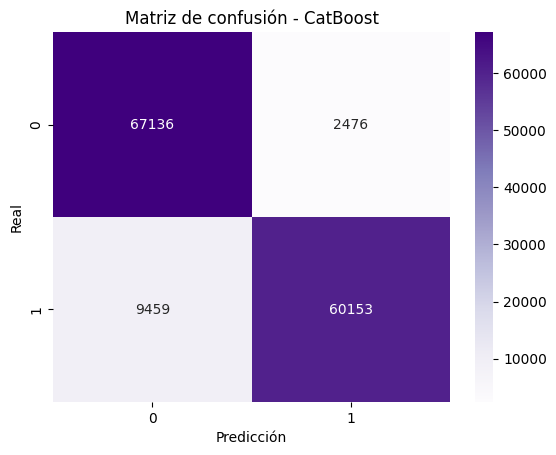

In [33]:
# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - CatBoost")
plt.show()

In [19]:
# Curva ROC para CatBoost
y_proba_cb = y_proba
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_proba_cb, pos_label=1)
auc_cb = roc_auc_score(y_test, y_proba_cb)

## SHAP con CatBoost

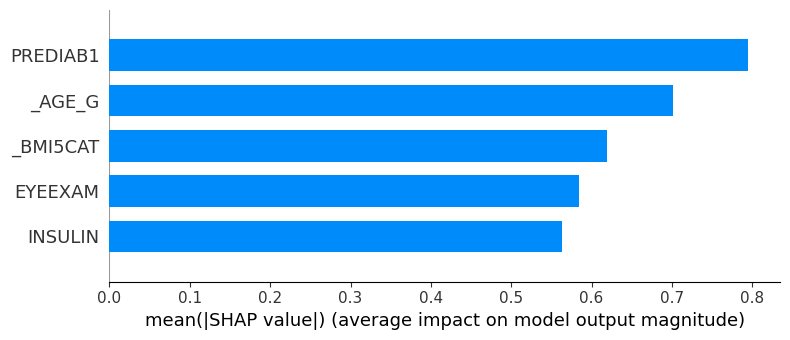

In [28]:
import joblib
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
import shap

# Cargar modelo y columnas
modelo_cb = joblib.load("modelos5/modelo_cb.pkl")
cols_cb = joblib.load("modelos5/columnas_cb.pkl")

# Cargar dataset
df = pd.read_csv("train_aif360_reweighing_rfe_smote.csv")
df = df.replace([888.0, 88.0, 77.0, 99.0], np.nan)

X = df[cols_cb].copy()
y = df["DIABETE3"]

# CatBoost requiere categóricas como string
cat_cols = ['PREDIAB1', '_BMI5CAT']
for col in cat_cols:
    X[col] = X[col].astype("string")

pool = Pool(X, y, cat_features=cat_cols)

shap_values = modelo_cb.get_feature_importance(pool, type="ShapValues")
shap_values_no_bias = shap_values[:, :-1]  # quitar columna de bias

shap.summary_plot(shap_values_no_bias, X, plot_type="bar")
